### Occlusion Visualization

In [99]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

import torch
import torch.nn as nn
from torchvision import transforms, utils
from torchvision import models
from torch.autograd import Variable
from torchvision.utils import make_grid

### 1. Load Image & Labels

(-0.5, 999.5, 999.5, -0.5)

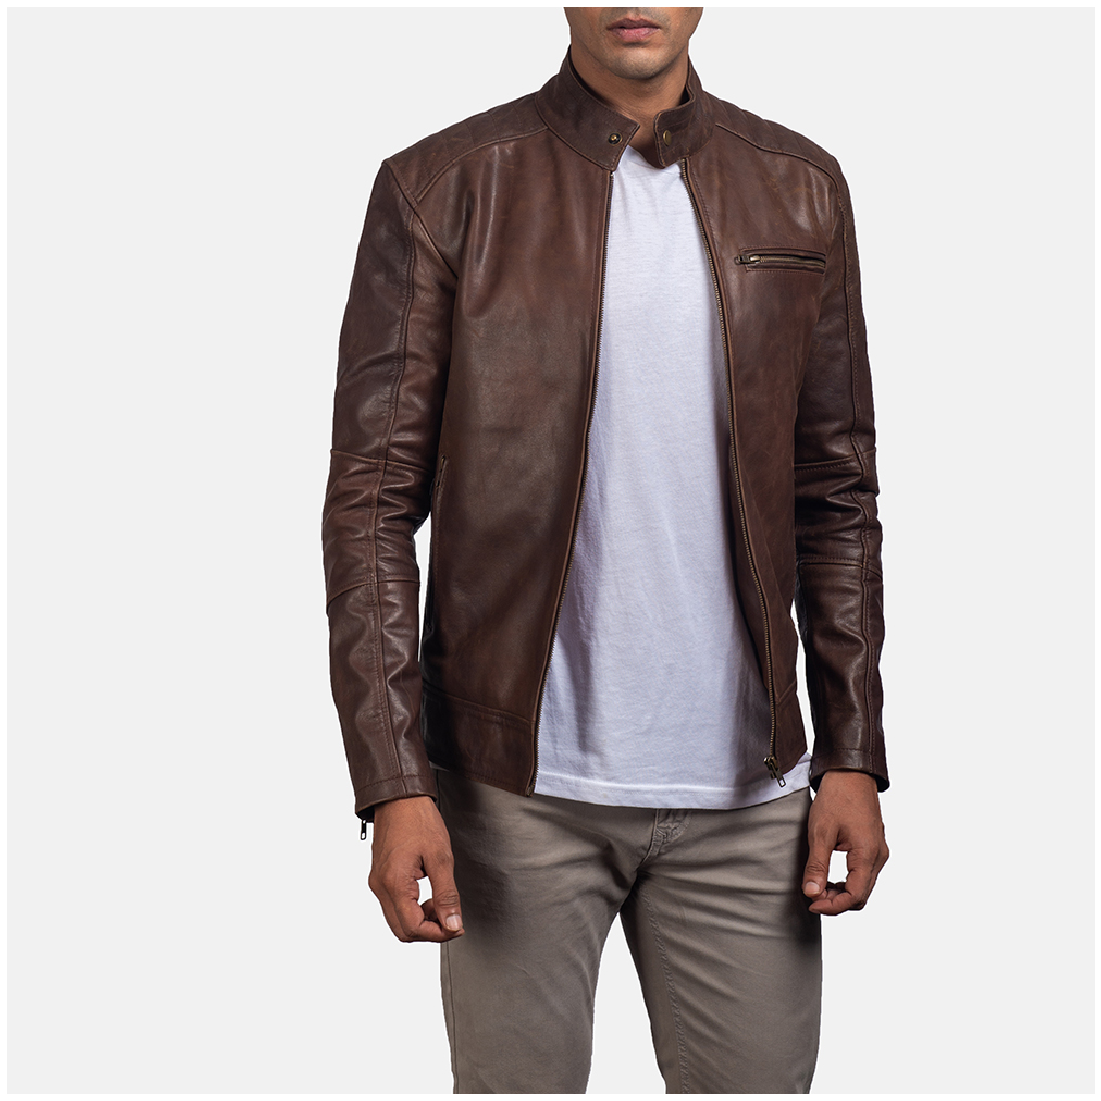

In [177]:
image_path = 'images/test05.jpg'
my_image = Image.open(image_path)
labels = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
classes = {int(key):value for (key, value) in requests.get(labels).json().items()}
plt.imshow(my_image)
plt.axis('off')

### 2. Preprocess Image data

In [178]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])
])
my_image = Variable(preprocess(my_image).unsqueeze(0).cuda())

### 3. Load model & Predict Original Image

In [214]:
model = models.vgg16(pretrained=True).cuda()
_, predict_idx = model(my_image).data[0].max(0)
classes[predict_idx.item()]

'suit, suit of clothes'

### 4. Occlusion 

In [206]:
occlusion_size = 43
stride = occlusion_size
visual_map = torch.zeros(int(((my_image.shape[2]-occlusion_size)/stride)+1), 
                      int(((my_image.shape[3]-occlusion_size)/stride)+1))
my_image = my_image.data

i, a = 0, 0
show_images = []
while i <= my_image.shape[3]-occlusion_size:
    j, b = 0, 0
    while j <= my_image.shape[2]-occlusion_size:
        h_filter = torch.ones(my_image.shape)
        h_filter[:,:,i:i+occlusion_size, j:j+occlusion_size] = 0
        temp_image = my_image * h_filter.cuda()
        temp_image_ = temp_image.squeeze(0)
        show_images.append(temp_image_)
        temp_output = model(temp_image)
        _, predict_idx_ = temp_output.data[0].max(0)
        temp_softmax = torch.nn.functional.softmax(temp_output).data[0]
        visual_map[a][b] = temp_softmax[predict_idx_.item()]
        j += stride
        b += 1
    i += stride
    a += 1     

/home/jhpark15/.conda/envs/jhpark15/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### 5. Map Visualization

(-0.5, 4.5, 4.5, -0.5)

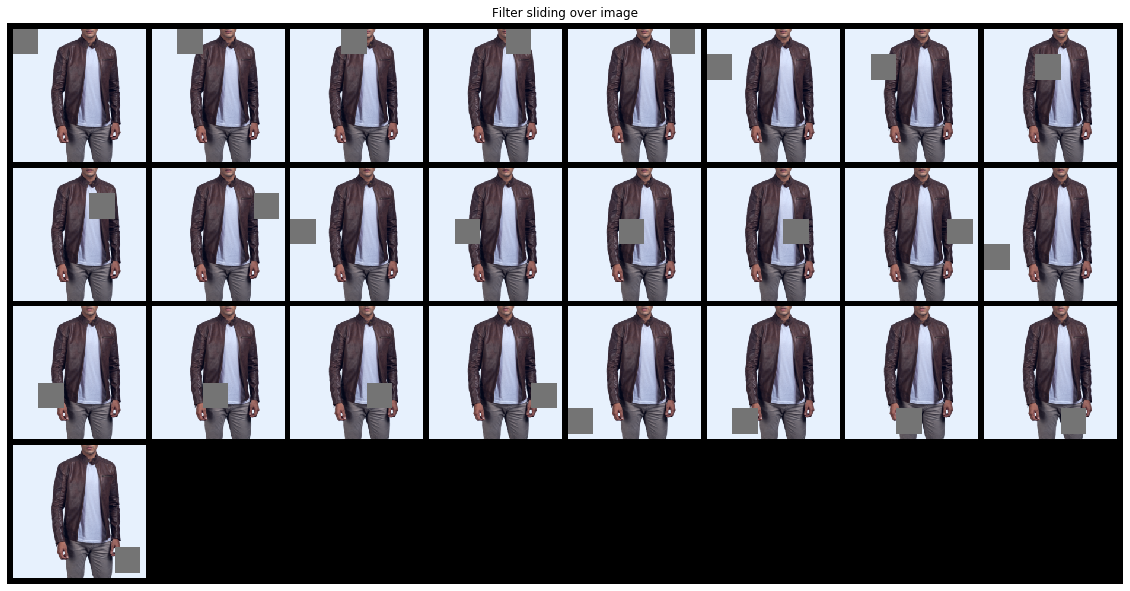

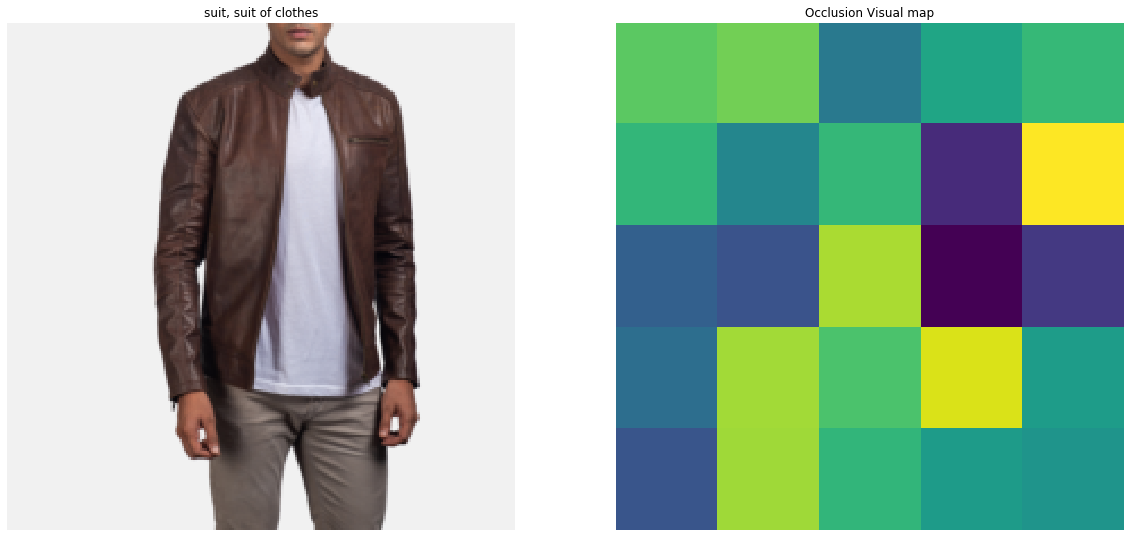

In [217]:
image = my_image.squeeze(0)
image = image.transpose(0,1).transpose(1,2)
image = image*torch.Tensor([0.229, 0.224, 0.225]).cuda()+torch.Tensor([0.485, 0.456, 0.406]).cuda()

npimg = make_grid(show_images, padding = 10, normalize=True).cpu().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.title('Filter sliding over image')
plt.axis('off')

# Plot both images
fig = plt.figure()
plt.rcParams["figure.figsize"] = (15 ,15)
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(image.cpu())
plt.title('Prediction :' + classes[predict_idx.item()])
plt.axis('off')

visual_map_ = visual_map - visual_map.min()
visual_map_ = np.uint8(255 * visual_map_)

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(visual_map)
plt.title('Occlusion Visual map')
plt.axis('off')